In [ ]:
# install igraph for graph analytics

!pip install python-igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 12.0 MB/s eta 0:00:00


In [ ]:
# install cairocffi for graph visualization within igraph

!pip install cairocffi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 1.9 MB/s eta 0:00:00


In [ ]:
# imports

from math import sqrt, pi
from typing import List
import cairocffi as cairo
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

LAT = 'INTPTLAT'  # these are the labels used for latitude and longitude
LON = 'INTPTLON'  # in the census data

In [ ]:
# read a csv or excel file into a dataframe

def load_file(filename: str) -> pd.DataFrame:
  file_ext = filename.split('.')[-1]

  if file_ext == 'csv':
    df = pd.DataFrame(pd.read_csv(filename))
  elif file_ext == 'xlsx':
    df = pd.DataFrame(pd.read_excel(filename))
  else:
    df = pd.DataFrame()

  if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

  return df

In [ ]:
# load data from files

facilities = load_file('facility_locations.xlsx')
undesirable_facilities = facilities.loc[facilities['desirable'] == 0]
undesirable_facilities.reset_index(inplace=True, drop=True)
desirable_facs = facilities.loc[facilities['desirable'] == 1]
desirable_facs.reset_index(inplace=True, drop=True)
desirable_facs.insert(len(desirable_facs.columns), 'node', 'none')
desirable_facs.insert(len(desirable_facs.columns), 'diff', 0.)
data = load_file('node_data.csv')  # final data file with population standardization


<br/>
<br/>
<h3>THESE FUNCTIONS ARE FOR CALCULATING FAIRNESS AND DISTANCES FROM UNDESIRABLE FACILITIES TO CENSUS TRACTS<h3/>

In [ ]:
# create an object for points of interest, used in other functions for calculating distances

def new_poi(name: str, lat: float, lon: float) -> pd.DataFrame:
  return pd.DataFrame({'name': name, 'INTPTLAT': [lat], 'INTPTLON': [lon]})

In [ ]:
# calculate Euclidian distance between two points in two dimensional space

def eucl_dist(x1, y1, x2, y2) -> float:
    return sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [ ]:
# calculate Euclidian distances between a POI and set of other points

def eucl_dist_batch(poi: pd.DataFrame, tracts: pd.DataFrame) -> pd.DataFrame:
  distances = pd.DataFrame({'name': np.zeros_like(tracts.loc[:, 'name']),
                            'dist': np.zeros_like(tracts.loc[:, 'name'])})
  x1 = poi.loc[0, LON]
  y1 = poi.loc[0, LAT]

  for i in range(len(tracts.loc[:, 'name'])):
    x2 = tracts.loc[i, LON]
    y2 = tracts.loc[i, LAT]
    distances.loc[i, 'name'] = tracts.loc[i, 'name']
    distances.loc[i, 'dist'] = eucl_dist(x1, y1, x2, y2)

  return distances

In [ ]:
# calculate average cluster distances from a POI, weighted for normalized population
# this is for undesirable facilities

def calc_avg_distances(poi: pd.DataFrame, data: pd.DataFrame, columns) -> pd.DataFrame:
  distances = eucl_dist_batch(poi, data)
  results = pd.DataFrame(np.zeros((1,5)), columns=columns)

  cluster_counts = [0, 0, 0, 0, 0]
  for i in range(len(distances.loc[:, 'name'])):
    if distances.loc[i, 'name'] == data.loc[i, 'name']:
      results.loc[0, 'overall'] += distances.loc[i, 'dist'] * data.loc[i, 'popN']
      results.iloc[0, data.loc[i, 'cluster']] += distances.loc[i, 'dist'] * data.loc[i, 'popN']
      cluster_counts[0] += 1
      cluster_counts[data.loc[i, 'cluster']] += 1
    else:
      results.loc[0, 'overall'] = -1.
      break

  for i in range(len(results.columns)):
    results.iloc[0, i] /= cluster_counts[i]
    results.iloc[0, i] *= 1000

  results.insert(0, 'name', poi.loc[0, 'name'])

  return results

In [ ]:
# calculate average cluster distances for a set of POIs

def calc_avg_dist_batch(facilities: pd.DataFrame, data: pd.DataFrame):
  columns=['name', 'overall', 'LILE', 'LIME', 'HILE', 'HIHE']
  results = pd.DataFrame(columns=columns)

  for i in range(len(facilities.index)):
    poi = new_poi(facilities.loc[i, 'name'], facilities.loc[i, LAT], facilities.loc[i, LON])
    results = pd.concat((results, calc_avg_distances(poi, data, columns[1:])), ignore_index=True)

  return results

In [ ]:
# calculate average cluster distances for undesirable facilities and export to CSV

calc_avg_dist_batch(undesirable_facilities, data).to_csv('undesirable_facs.csv', index=False)

<br/>
<br/>
<h3>THIS IS WHERE WE BUILD THE GRAPH</h3>

In [ ]:
# load from gml if it's available

g = ig.Graph.Read_GML('spokane_graph.gml')

In [ ]:
# load the edge data into a dataframe

edge_list = load_file('edge_list_weighted.csv')
edge_list

In [ ]:
# load the vertex data into a dataframe

vertex_list = load_file('node_data.csv')
vertex_list

In [ ]:
# construct the graph if GML input wasn't used
g = ig.Graph()

# cull the tracts we aren't using and add them as vertices
vertex_list = data.loc[data['City'] == 1].reset_index(drop=True)
g.add_vertices(vertex_list.loc[:, 'name'])
g.vs['INTPTLAT'] = vertex_list.loc[:, 'INTPTLAT']
g.vs['INTPTLON'] = vertex_list.loc[:, 'INTPTLON']
g.vs['cluster'] = vertex_list.loc[:, 'cluster']
g.vs['popN'] = vertex_list.loc[:, 'popN']

# colors are: NA, orange (#fa8805), yellow (#fad905), aqua (#05faf6), blue (#056ffa)
# colors = ['', "250, 217, 5", "5, 111, 250", "250, 136, 5", "5, 250, 238"]
colors = ['', "#fa8805", "#fad905", "#05faf6", "#056ffa"]
for i in range(len(g.vs)):
  g.vs[i]['color'] = colors[int(g.vs[i]['cluster'])]

# format edge data for igraph and add to graph
edges = []
for i in range(len(edge_list.index)):
  edges.append((edge_list.loc[i, 'source'], edge_list.loc[i, 'destination']))
g.add_edges(edges)
g.es['weight'] = edge_list.loc[:, 'weight']

In [ ]:
# show vertices

g.get_vertex_dataframe()

In [ ]:
# show edges

g.get_edge_dataframe()

In [ ]:
# export graph to GML

g.write_gml('spokane_graph.gml')

</br></br>
<h3>THIS IS WHERE WE SET UP THE PLOT</h3>

In [ ]:
# add coordinates to each vertex

new_coords = []
vertices = g.get_vertex_dataframe()

for i in range(len(g.vs)):
  new_coords.append([vertices.loc[i, LON], -vertices.loc[i, LAT]])

new_layout = ig.Layout(coords=new_coords)

# set vertex label position and distance so they don't overlap

new_pos = []

for i in range(len(g.vs)):
  if g.vs[i]['name'] == 'CT 3.02':
    new_pos.append(3 * pi / 2) # bottom
  elif g.vs[i]['name'] == 'CT 12':
    new_pos.append(3 * pi / 2) # bottom
  elif g.vs[i]['name'] == 'CT 20':
    new_pos.append(3 * pi / 2) # bottom
  elif g.vs[i]['name'] == 'CT 25.02':
    new_pos.append(3 * pi / 2) # bottom
  elif g.vs[i]['name'] == 'CT 40.01':
    new_pos.append(3 * pi / 2) # bottom
  elif g.vs[i]['name'] == 'CT 47.02':
    new_pos.append(3 * pi / 2) # bottom
  elif g.vs[i]['name'] == 'CT 23':
    new_pos.append(pi) # left
  elif g.vs[i]['name'] == 'CT 36.01':
    new_pos.append(pi) # left
  elif g.vs[i]['name'] == 'CT 39':
    new_pos.append(pi) # left
  elif g.vs[i]['name'] == 'CT 40.02':
    new_pos.append(pi) # left
  elif g.vs[i]['name'] == 'CT 42':
    new_pos.append(pi) # left
  elif g.vs[i]['name'] == 'CT 112.04':
    new_pos.append(0) # right
  elif g.vs[i]['name'] == 'CT 2.01':
    new_pos.append(0) # right
  elif g.vs[i]['name'] == 'CT 2.02':
    new_pos.append(0) # right
  elif g.vs[i]['name'] == 'CT 41':
    new_pos.append(0) # right
  elif g.vs[i]['name'] == 'CT 145':
    new_pos.append(0) # right
  else:
    #new_pos.append(0) # right
    new_pos.append(pi / 2) # top
    #new_pos.append(pi) # left
    #new_pos.append(3 * pi / 2) # bottom

new_dist = []

for i in range(len(g.vs)):
  if g.vs[i]['name'] == 'CT 111.04':
    new_dist.append(3)
  elif g.vs[i]['name'] == 'CT 108':
    new_dist.append(3)
  elif g.vs[i]['name'] == 'CT 109.02':
    new_dist.append(3)
  elif g.vs[i]['name'] == 'CT 110':
    new_dist.append(3)
  else:
    new_dist.append(1.5)


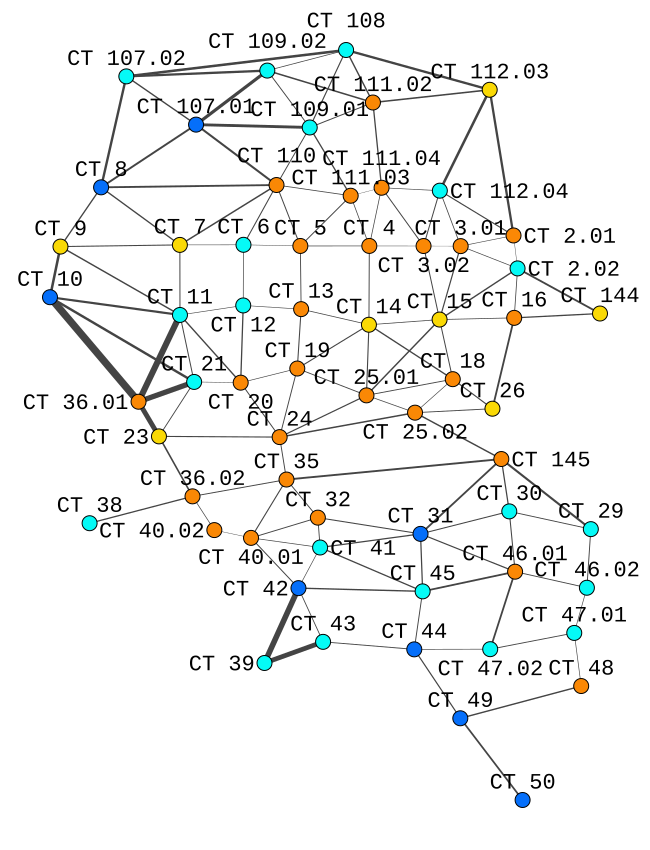

In [ ]:
# visualize the graph for "City of Spokane Graph" figure

ig.plot(g,
        layout=new_layout,
        vertex_size=15,
        vertex_label=g.vs['name'],
        vertex_label_angle=new_pos,
        vertex_label_dist=new_dist,
        vertex_label_size=22,
        vertex_label_color='black',
        edge_width=[weight / 2 for weight in g.es['weight']],
        colors=g.vs['color'],
        bbox=(0, 0, 650, 850),
        margin=50,
        target='latlon_graph.pdf')

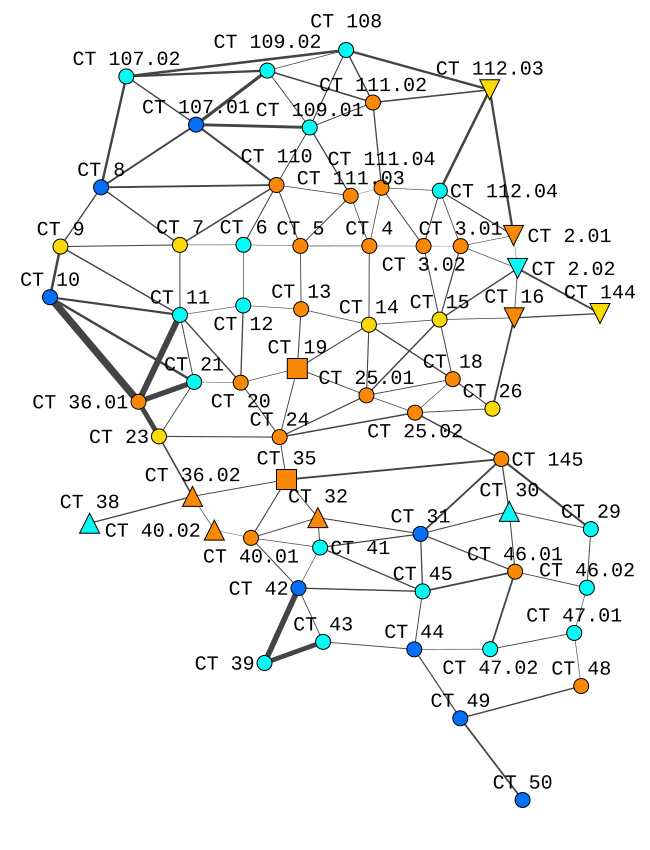

In [ ]:
# visualize the graph for "Centrality and Fairness Graph" figure
# be sure to add coordinates to each vertex and set vertex label position
# and distance (SEE ABOVE)

# set vertex shapes

new_shape = []
new_vert_size = []

for i in range(len(g.vs)):
  if g.vs[i]['name'] == 'CT 19':
    new_shape.append('rectangle')
    new_vert_size.append(20)
  elif g.vs[i]['name'] == 'CT 35':
    new_shape.append('rectangle')
    new_vert_size.append(20)
  elif g.vs[i]['name'] == 'CT 2.01':
    new_shape.append('triangle-down')
    new_vert_size.append(20)
  elif g.vs[i]['name'] == 'CT 2.02':
    new_shape.append('triangle-down')
    new_vert_size.append(20)
  elif g.vs[i]['name'] == 'CT 16':
    new_shape.append('triangle-down')
    new_vert_size.append(20)
  elif g.vs[i]['name'] == 'CT 112.03':
    new_shape.append('triangle-down')
    new_vert_size.append(20)
  elif g.vs[i]['name'] == 'CT 144':
    new_shape.append('triangle-down')
    new_vert_size.append(20)
  elif g.vs[i]['name'] == 'CT 30':
    new_shape.append('triangle-up')
    new_vert_size.append(20)
  elif g.vs[i]['name'] == 'CT 32':
    new_shape.append('triangle-up')
    new_vert_size.append(20)
  elif g.vs[i]['name'] == 'CT 36.02':
    new_shape.append('triangle-up')
    new_vert_size.append(20)
  elif g.vs[i]['name'] == 'CT 38':
    new_shape.append('triangle-up')
    new_vert_size.append(20)
  elif g.vs[i]['name'] == 'CT 40.02':
    new_shape.append('triangle-up')
    new_vert_size.append(20)
  else:
    new_shape.append('circle')
    new_vert_size.append(15)

ig.plot(g,
        layout=new_layout,
        vertex_size=new_vert_size,
        vertex_label=g.vs['name'],
        vertex_label_angle=new_pos,
        vertex_label_dist=new_dist,
        vertex_label_size=20,
        vertex_shape=new_shape,
        vertex_label_color='black',
        edge_width=[weight / 2 for weight in g.es['weight']],
        colors=g.vs['color'],
        bbox=(0, 0, 650, 850),
        margin=50,
        target='centrality_fairness_graph.png')

</br></br>
<h3>THESE FUNCTIONS ARE FOR CALCULATING CENTRALITY AND FAIRNESS VALUES FOR DESIRABLE FACILITIES</h3>

In [ ]:
# calculate eccentricity centrality using edge weights

def eccentricity_weighted(graph: ig.Graph) -> pd.DataFrame:
  results = pd.DataFrame()
  results.insert(0, 'c_e', np.zeros(len(graph.vs)))
  all_distances = pd.DataFrame(np.zeros((len(graph.vs), len(graph.vs))))

  # calculate weighted distances of all shortest paths
  for i in range(len(graph.vs)):  # i: current node
    all_shortest_path = graph.get_shortest_paths(i, weights=graph.es['weight'], output='epath')
    for j in range(len(all_shortest_path)):  # j: current shortest path to another node
      for k in range(len(all_shortest_path[j])):  # k: edge in that path
        all_distances.iloc[i, j] += graph.es[all_shortest_path[j][k]]['weight']

  for i in range(len(graph.vs)):  # find eccentricity centrality for each node
    results.iloc[i, 0] = 1 / max(all_distances.iloc[i])

  return results


In [ ]:
# calculate various types of centrality on the graph and report top vertices

def calc_centrality(graph: ig.Graph) -> pd.DataFrame:
  results = {}
  vert = graph.get_vertex_dataframe()

  calcs = pd.DataFrame()
  calcs.insert(len(calcs.columns), 'c_e', np.zeros_like(graph.vs['name']))
  calcs.insert(len(calcs.columns), 'c_c', np.zeros_like(graph.vs['name']))
  calcs.insert(len(calcs.columns), 'c_h', np.zeros_like(graph.vs['name']))

  ecc_wt = eccentricity_weighted(graph)

  for i in range(len(graph.vs)):
    calcs.loc[i, 'c_c'] = graph.closeness(vertices=graph.vs[i], weights=graph.es['weight'])
    calcs.loc[i, 'c_e'] = ecc_wt.loc[i, 'c_e']
    calcs.loc[i, 'c_h'] = graph.harmonic_centrality(vertices=graph.vs[i], weights=graph.es['weight'])

  calcs.loc[:, 'c_i'] = graph.eigenvector_centrality(weights=graph.es['weight'])

  c_e = calcs.loc[:, 'c_e'].to_list().index(max(calcs.loc[:, 'c_e']))
  c_c = calcs.loc[:, 'c_c'].to_list().index(max(calcs.loc[:, 'c_c']))
  c_h = calcs.loc[:, 'c_h'].to_list().index(max(calcs.loc[:, 'c_h']))
  c_i = calcs.loc[:, 'c_i'].to_list().index(max(calcs.loc[:, 'c_i']))

  results['c_e'] = {'index': c_e,
                    'node': graph.vs[c_e]['name'],
                    'val': calcs.loc[c_e, 'c_e']}
  results['c_c'] = {'index': c_c,
                    'node': graph.vs[c_c]['name'],
                    'val': calcs.loc[c_c, 'c_c']}
  results['c_h'] = {'index': c_h,
                    'node': graph.vs[c_h]['name'],
                    'val': calcs.loc[c_h, 'c_h']}
  results['c_i'] = {'index': c_i,
                    'node': graph.vs[c_i]['name'],
                    'val': calcs.loc[c_i, 'c_i']}
  results = pd.DataFrame(data=results)

  return results

In [ ]:
# calculate eccentricity and closeness and report for ALL nodes

def calc_ecc_close(graph: ig.Graph) -> pd.DataFrame:
  calcs = pd.DataFrame()
  calcs.insert(0, 'name', graph.vs['name'])
  calcs.insert(len(calcs.columns), 'eccentricity', np.zeros_like(graph.vs['name']))
  calcs.insert(len(calcs.columns), 'closeness', np.zeros_like(graph.vs['name']))

  ecc_wt = eccentricity_weighted(graph)

  for i in range(len(graph.vs)):
    calcs.loc[i, 'closeness'] = graph.closeness(vertices=graph.vs[i], weights=graph.es['weight']) ** -1
    calcs.loc[i, 'eccentricity'] = ecc_wt.loc[i, 'c_e'] ** -1

  return calcs

In [ ]:
# calculate average cluster distance using weighted shortest paths
# this is for desirable facilities

def cluster_dist_avg(target_name: str, graph: ig.Graph) -> List:
  target_id = -1

  for i in range(len(graph.vs)):
    if target_name == graph.vs[i]['name']:
      target_id = i

  cluster_totals = [0., 0., 0., 0., 0.]
  cluster_counts = [0, 0, 0, 0, 0]

  all_shortest_path = graph.get_shortest_paths(target_id, weights=graph.es['weight'], output='epath')

  for i in range(len(all_shortest_path)):  # for each shortest path
    cluster_counts[int(graph.vs[i]['cluster'])] += 1
    for j in range(len(all_shortest_path[i])):  # for each edge in that path
      cluster_totals[int(graph.vs[i]['cluster'])] += graph.es[all_shortest_path[i][j]]['weight']

  for i in range(len(cluster_totals)):
    if cluster_counts[i] == 0:
      pass
    else:
      cluster_totals[i] /= cluster_counts[i]

  return cluster_totals[1:]

In [ ]:
# calculate max differences between average cluster distances for each node
# this is a fairness metric

def clust_diff_all_nodes(graph: ig.Graph) -> pd.DataFrame:
  clust_diffs = pd.DataFrame()
  clust_diffs.insert(len(clust_diffs.columns), 'clust1', np.zeros_like(graph.vs['name']))
  clust_diffs.insert(len(clust_diffs.columns), 'clust2', np.zeros_like(graph.vs['name']))
  clust_diffs.insert(len(clust_diffs.columns), 'clust3', np.zeros_like(graph.vs['name']))
  clust_diffs.insert(len(clust_diffs.columns), 'clust4', np.zeros_like(graph.vs['name']))

  for i in range(len(clust_diffs.index)):
    clust_diffs.iloc[i] = cluster_dist_avg(graph.vs[i]['name'], graph)

  clust_diffs.insert(0, 'max_diff', np.zeros_like(graph.vs['name']))

  for i in range(len(clust_diffs.index)):
    clust_diffs.loc[i, 'max_diff'] = max(clust_diffs.iloc[i, 1:]) - min(clust_diffs.iloc[i, 1:])

  clust_diffs.insert(0, 'name', graph.vs['name'])
  clust_diffs.sort_values(by='max_diff', axis=0, ignore_index=True, inplace=True)
  clust_diffs.to_csv('clust_diffs.csv')

  '''results = pd.DataFrame(data=np.zeros((10,2)), columns=['name', 'diff'])
  for i in range(5):
    results.loc[i, 'name'] = clust_diffs.loc[i, 'name']
    results.loc[i, 'diff'] = clust_diffs.loc[i, 'max_diff']
    results.loc[len(results.index) - 1 - i, 'name'] = clust_diffs.loc[len(clust_diffs.index) - 1 - i, 'name']
    results.loc[len(results.index) - 1 - i, 'diff'] = clust_diffs.loc[len(clust_diffs.index) - 1 - i, 'max_diff']'''

  return clust_diffs

In [ ]:
# find the closest vertex to a POI's location

def assign_poi_to_node(poi: pd.DataFrame, graph: ig.Graph) -> pd.DataFrame:
  distances = eucl_dist_batch(poi, graph.get_vertex_dataframe())
  min_idx = np.argmin(distances.loc[:, 'dist'].to_numpy())

  return distances.loc[min_idx, 'name']

In [ ]:
#  calculate fairness of desirable facility locations

def desirable_facs_fairness(facilities: pd.DataFrame, graph: ig.Graph) -> pd.DataFrame:
  for i in range(len(facilities.index)):
    poi = new_poi(facilities.loc[i, 'name'], facilities.loc[i, LAT], facilities.loc[i, LON])
    facilities.loc[i, 'node'] = assign_poi_to_node(poi, graph)

  all_nodes_diff = clust_diff_all_nodes(graph)
  all_nodes_diff.set_index('name', inplace=True)

  for i in range(len(facilities.index)):
    facilities.loc[i, 'diff'] = all_nodes_diff.loc[facilities.loc[i, 'node'], 'max_diff']

  return facilities

</br></br>
<h3>CENTRALITY RESULTS</h3>

In [ ]:
calc_centrality(g)

,c_e,c_c,c_h,c_i
index,30,18,3,31
node,CT 35,CT 19,CT 3.02,CT 36.01
val,0.061728,0.134613,0.217267,1.0


</br></br>
<h3>FAIRNESS RESULTS</h3>

In [ ]:
clust_diff_results = clust_diff_all_nodes(g)
#clust_diff_results.set_index('name', inplace=True)
clust_diff_results

In [ ]:
#desirable_facs_fairness(desirable_facs, g).to_csv('des_fac_fair.csv', index=False)
des_facs_results = desirable_facs_fairness(desirable_facs, g)
des_facs_results

,name,INTPTLAT,INTPTLON,desirable,category,node,diff
0,riverfront_park,47.662186,-117.419102,1,0,CT 35,2.850000
1,riverside_state_park,47.696685,-117.494835,1,0,CT 10,3.687500
2,franklin_park,47.706283,-117.413901,1,0,CT 5,6.381250
3,dwight_merkel_sports_complex,47.709502,-117.479016,1,0,CT 9,5.256250
4,audubon_park,47.690213,-117.453725,1,0,CT 11,5.337500
5,firestation_1,47.658431,-117.412880,1,1,CT 35,2.850000
6,firestation_2,47.683873,-117.394643,1,1,CT 15,7.650000
7,firestation_3,47.674834,-117.437755,1,1,CT 21,4.250000
8,firestation_4,47.656069,-117.435072,1,1,CT 36.02,1.970192
9,firestation_5,47.598401,-117.412396,1,1,CT 39,5.181250


</br></br>
<h3>OPTIMIZATION RESULTS</h3>

In [ ]:
# get eccentricity and closeness for all nodes

ecc_close_results = calc_ecc_close(g)
ecc_close_results.insert(1, 'diff', 0.)

for i in range(len(ecc_close_results)):
  name = ecc_close_results.loc[i, 'name']
  ecc_close_results.loc[i, 'diff'] = clust_diff_results.loc[name, 'max_diff']

In [ ]:
# normalize all values so that difference and ecc/cln are weighted equally for objective function

for i in range(len(ecc_close_results)):
  ecc_close_results.loc[i, 'diff'] /= max(ecc_close_results.loc[:, 'diff'])
  ecc_close_results.loc[i, 'eccentricity'] /= max(ecc_close_results.loc[:, 'eccentricity'])
  ecc_close_results.loc[i, 'closeness'] /= max(ecc_close_results.loc[:, 'closeness'])

In [ ]:
# calculate values for objective function using average population-weighted cluster distance differences and eccentricity or closeness

ecc_close_results.insert(1, 'obj_ecc', 0.)
ecc_close_results.insert(1, 'obj_cln', 0.)

for i in range(len(ecc_close_results)):
  ecc_close_results.loc[i, 'obj_ecc'] = ecc_close_results.loc[i, 'diff'] + ecc_close_results.loc[i, 'eccentricity']
  ecc_close_results.loc[i, 'obj_cln'] = ecc_close_results.loc[i, 'diff'] + ecc_close_results.loc[i, 'closeness']

In [ ]:
ecc_close_results

,name,obj_cln,obj_ecc,diff,eccentricity,closeness
0,CT 2.01,1.431309,1.772851,0.950066,0.822785,0.481243
1,CT 2.02,1.402568,1.740066,0.936268,0.803797,0.4663
2,CT 3.01,1.305078,1.657346,0.872536,0.78481,0.432541
3,CT 3.02,1.258636,1.612078,0.846255,0.765823,0.412381
4,CT 4,1.170807,1.513951,0.776610,0.737342,0.394197
...,...,...,...,...,...,...
57,CT 111.04,1.454104,1.591696,0.778581,0.813115,0.675523
58,CT 112.03,2.000000,2.000000,1.000000,1.0,1.0
59,CT 112.04,1.715791,1.849340,0.871812,0.977528,0.843979
60,CT 144,2.000000,2.000000,1.000000,1.0,1.0


In [ ]:
# get top 5 nodes based on eccentricity

top_ecc = ecc_close_results.sort_values('obj_ecc', ignore_index=True).iloc[0:5]
top_ecc

,name,obj_cln,obj_ecc,diff,eccentricity,closeness
0,CT 36.02,0.649224,0.745091,0.207116,0.537975,0.442108
1,CT 35,0.686885,0.812264,0.299606,0.512658,0.387279
2,CT 40.02,0.787627,0.825302,0.250935,0.574367,0.536692
3,CT 38,0.772559,0.827369,0.207116,0.620253,0.565443
4,CT 32,0.715457,0.858745,0.285960,0.572785,0.429498


In [ ]:
# get top 5 nodes based on closeness

top_cln = ecc_close_results.sort_values('obj_cln', ignore_index=True).iloc[0:5]
top_cln

,name,obj_cln,obj_ecc,diff,eccentricity,closeness
0,CT 36.02,0.649224,0.745091,0.207116,0.537975,0.442108
1,CT 35,0.686885,0.812264,0.299606,0.512658,0.387279
2,CT 32,0.715457,0.858745,0.285960,0.572785,0.429498
3,CT 23,0.753350,0.921434,0.331244,0.59019,0.422105
4,CT 31,0.768606,0.935814,0.296573,0.639241,0.472032
